# Feature Extraction: Version 1

In [1]:
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
from PIL import Image
from sklearn.manifold import TSNE

In [2]:
TRAIN_DIR = "../data/train"
CLASSES = ["Class A", "Class B", "Class C", "Class D"]
NUM_SAMPLES = 3

## Loading Sample Images and Visualizing them

Visualizing three samples from each class:

Class A


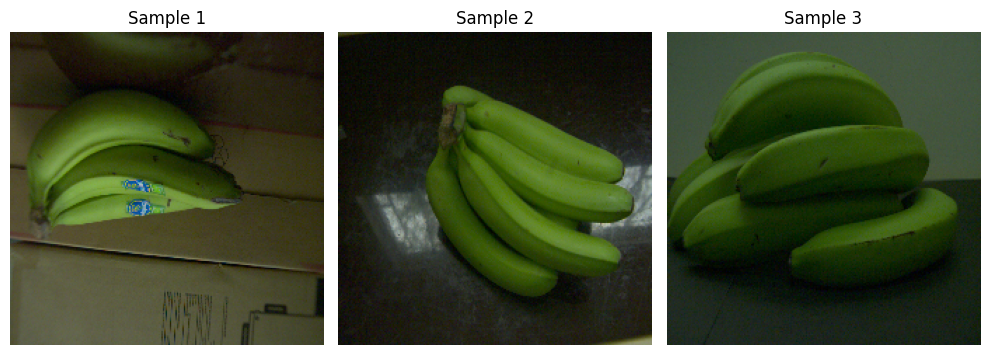

Class B


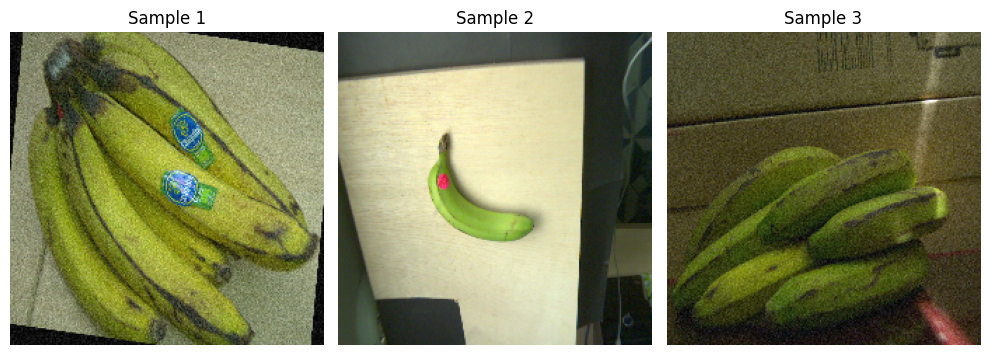

Class C


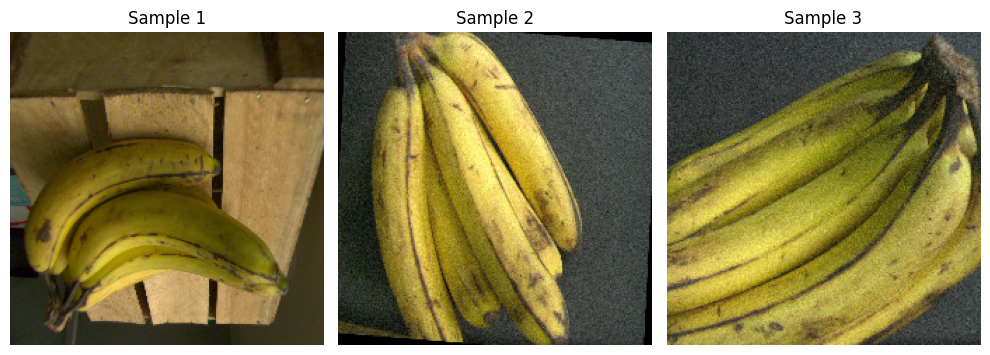

Class D


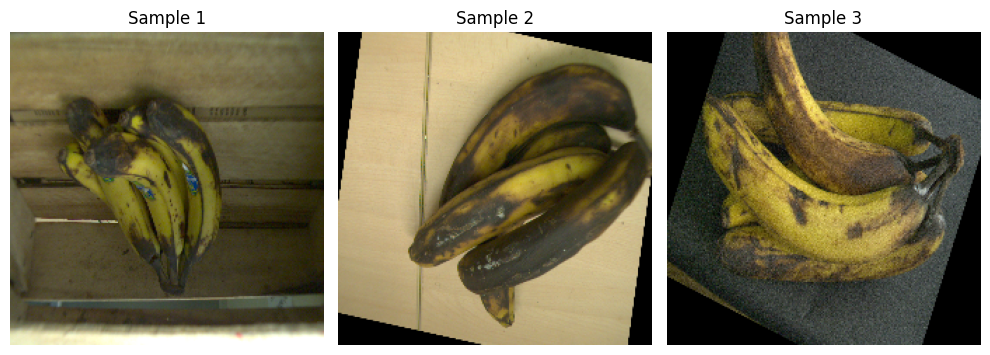

In [3]:
for class_name in CLASSES:
    class_path = os.path.join(TRAIN_DIR, class_name)
    if os.path.isdir(class_path):
        print(f"{class_name}")
        image_files = os.listdir(class_path)
        sample_images = random.sample(image_files, NUM_SAMPLES)
        plt.figure(figsize=(10, 4))
        for i, img_file in enumerate(sample_images):
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path)

            plt.subplot(1, NUM_SAMPLES, i + 1)
            plt.imshow(img)
            plt.title(f"Sample {i + 1}")
            plt.axis("off")

        plt.tight_layout()
        plt.show()

## Basic Image Statistics

Given each class, what's the:
1. Mean pixel value
2. Standard deviation of pixel values
3. Median pixel value
4. Smallest image size
5. Largest image size

In [4]:
def compute_image_stats(directory, class_name):
    class_path = os.path.join(directory, class_name)
    image_files = os.listdir(class_path)

    pixel_values = []
    image_sizes = []

    for img_file in image_files:
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path)

        # Get image size
        height, width, _ = img.shape
        image_sizes.append((height, width))

        # Compute statistics
        pixel_values.extend(img.flatten())

    pixel_values = np.array(pixel_values)
    mean = np.mean(pixel_values)
    std_dev = np.std(pixel_values)
    median = np.median(pixel_values)
    smallest_size = min(image_sizes)
    largest_size = max(image_sizes)

    return mean, std_dev, median, smallest_size, largest_size

In [5]:
for class_name in CLASSES:
    mean, std_dev, median, smallest_size, largest_size = compute_image_stats(
        TRAIN_DIR, class_name
    )

    print(f"{class_name}")
    print(f"Mean pixel value: {mean}")
    print(f"Standard deviation of pixel values: {std_dev}")
    print(f"Median pixel value: {median}")
    print(f"Smallest image size: {smallest_size}")
    print(f"Largest image size: {largest_size}")
    print("------------------------")

Class A
Mean pixel value: 79.4768570944071
Standard deviation of pixel values: 55.88115979871165
Median pixel value: 67.0
Smallest image size: (224, 224)
Largest image size: (224, 224)
------------------------
Class B
Mean pixel value: 82.26443310141349
Standard deviation of pixel values: 56.9651358637794
Median pixel value: 70.0
Smallest image size: (224, 224)
Largest image size: (224, 224)
------------------------
Class C
Mean pixel value: 95.74331719981757
Standard deviation of pixel values: 64.57465691877704
Median pixel value: 87.0
Smallest image size: (224, 224)
Largest image size: (224, 224)
------------------------
Class D
Mean pixel value: 93.47025758140012
Standard deviation of pixel values: 63.097251699438644
Median pixel value: 83.0
Smallest image size: (224, 224)
Largest image size: (224, 224)
------------------------


* We can see that all the images in all the classes are conveniently of the dimensions (224, 224)
* We're going to assume the following when training using models:
    1. All images are of the dimensions (224, 224, 3), 3 being the number of color channels.
    2. Every image will have a banana - from either classes of ripeness (leading to positive class sampling).
    3. Every banana is of the Cavendish species and has a class assigned to it.

## RGB Statistics

Now let's look at statistics from each channel:

In [6]:
def compute_rbg_channel_stats(directory, class_name):
    class_path = os.path.join(directory, class_name)
    image_files = os.listdir(class_path)

    channel_stats = {
        "Red": {"pixel_values": [], "mean": 0, "std_dev": 0, "median": 0},
        "Green": {"pixel_values": [], "mean": 0, "std_dev": 0, "median": 0},
        "Blue": {"pixel_values": [], "mean": 0, "std_dev": 0, "median": 0},
    }

    for img_file in image_files:
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path)

        # Split channels
        b, g, r = cv2.split(img)

        # Compute statistics for each channel
        for channel, values in zip(["Red", "Green", "Blue"], [r, g, b]):
            channel_stats[channel]["pixel_values"].extend(values.flatten())

    # Compute statistics for each channel
    for channel in channel_stats:
        pixel_values = np.array(channel_stats[channel]["pixel_values"])
        channel_stats[channel]["mean"] = np.mean(pixel_values)
        channel_stats[channel]["std_dev"] = np.std(pixel_values)
        channel_stats[channel]["median"] = np.median(pixel_values)
        channel_stats[channel]["min"] = np.min(pixel_values)
        channel_stats[channel]["max"] = np.max(pixel_values)
        channel_stats[channel]["25th_percentile"] = np.percentile(pixel_values, 25)
        channel_stats[channel]["75th_percentile"] = np.percentile(pixel_values, 75)

    return channel_stats

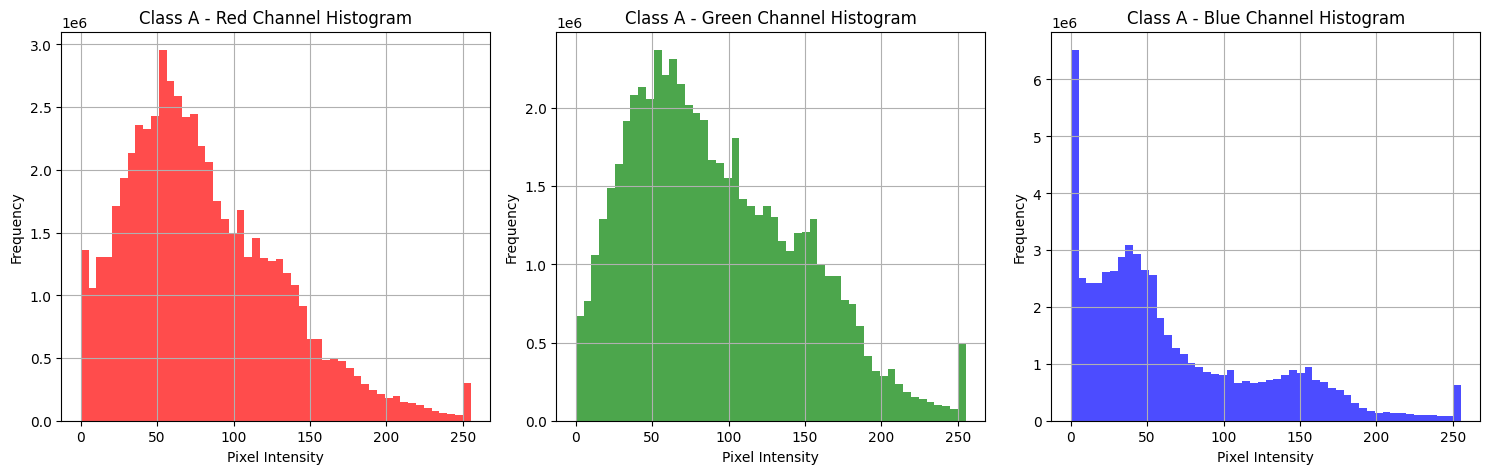

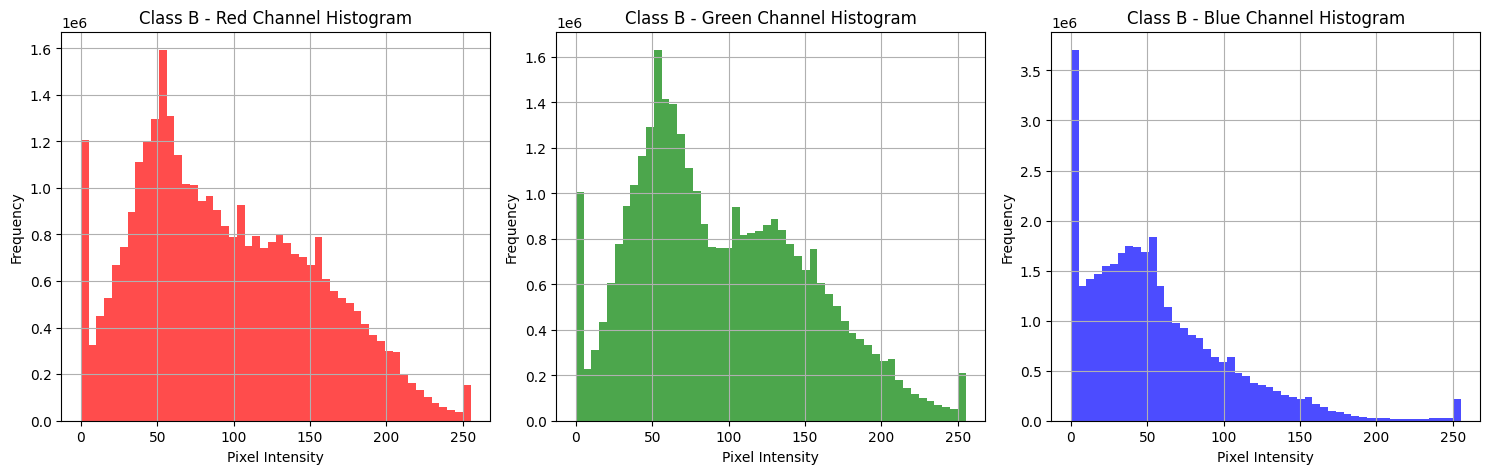

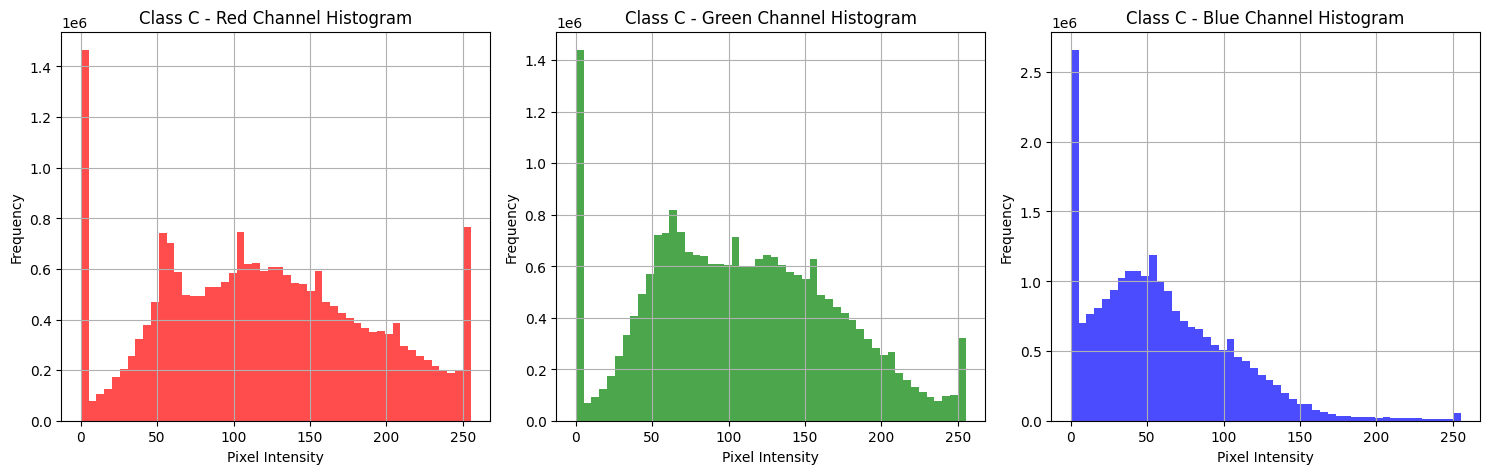

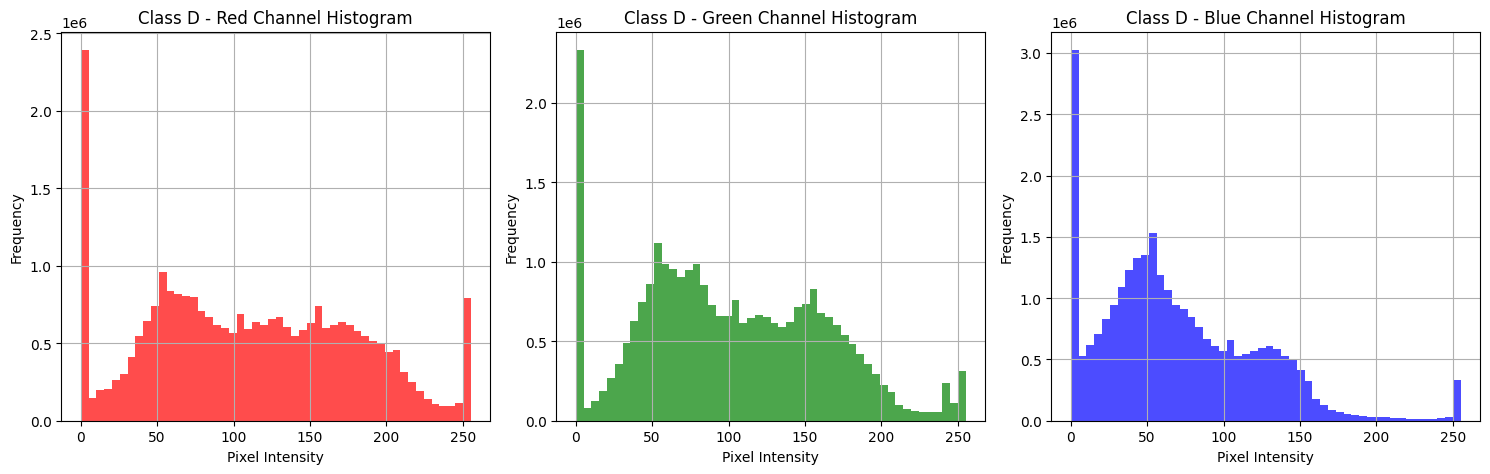

In [7]:
for class_name in CLASSES:
    rgb_stats = compute_rbg_channel_stats(TRAIN_DIR, class_name)

    plt.figure(figsize=(15, 5))
    for i, channel in enumerate(rgb_stats):
        plt.subplot(1, len(rgb_stats), i + 1)
        plt.hist(
            rgb_stats[channel]["pixel_values"],
            bins=50,
            color=channel.lower(),
            alpha=0.7,
        )
        plt.title(f"{class_name} - {channel} Channel Histogram")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

We can see that there some differences in the spreads among classes:
* Class A and B look similar accross the R and G channel but differ in distribution in the B channel.
* Class C and D have different distributions accross all thre channels.
* The range of pixel values seem consistent through the classes.
* For classes B, C, and D there seem to be several 0 intensities accross channels
* This leads us to the first challenge: it's difficult for human-beings to discern patterns when visualizing color distributions. 
* We'll see this getting increasingly challenging as we look at different color models.

In [8]:
all_stats = []
for class_name in CLASSES:
    rgb_stats = compute_rbg_channel_stats("../data/train", class_name)

    for channel, stats in rgb_stats.items():
        stats_to_store = {
            "Class": class_name,
            "Channel": channel,
            "Mean": stats["mean"],
            "Std Dev": stats["std_dev"],
            "Median": stats["median"],
            "Min": stats["min"],
            "Max": stats["max"],
            "25th Percentile": stats["25th_percentile"],
            "75th Percentile": stats["75th_percentile"],
        }
        all_stats.append(stats_to_store)
rgb_stats_df = pd.DataFrame(all_stats)

In [9]:
rgb_stats_df[rgb_stats_df["Channel"] == "Red"]

Class Channel        Mean    Std Dev  Median  Min  Max  25th Percentile  \
0  Class A     Red   80.437529  50.165098    72.0    0  255             43.0   
3  Class B     Red   95.137091  57.600736    86.0    0  255             49.0   
6  Class C     Red  119.856390  67.942900   117.0    0  255             66.0   
9  Class D     Red  110.341685  67.837330   107.0    0  255             57.0   

   75th Percentile  
0            112.0  
3            138.0  
6            169.0  
9            164.0

In [10]:
rgb_stats_df[rgb_stats_df["Channel"] == "Green"]

Class Channel        Mean    Std Dev  Median  Min  Max  25th Percentile  \
1   Class A   Green   92.310998  55.002141    83.0    0  255             49.0   
4   Class B   Green   95.803004  56.296089    86.0    0  255             52.0   
7   Class C   Green  108.611006  61.192415   106.0    0  255             63.0   
10  Class D   Green  100.801762  61.091903    94.0    0  255             55.0   

    75th Percentile  
1             130.0  
4             136.0  
7             152.0  
10            148.0

In [11]:
rgb_stats_df[rgb_stats_df["Channel"] == "Blue"]

Class Channel       Mean    Std Dev  Median  Min  Max  25th Percentile  \
2   Class A    Blue  65.682044  58.910139    46.0    0  255             21.0   
5   Class B    Blue  55.853205  46.919447    46.0    0  255             21.0   
8   Class C    Blue  58.762555  45.103383    52.0    0  255             24.0   
11  Class D    Blue  69.267327  51.821692    60.0    0  255             32.0   

    75th Percentile  
2              99.0  
5              79.0  
8              86.0  
11            102.0

Looking at the statistics in tabular format, it's easier to tell differences among color channels:
* Red Channel:
    * There is a large difference among the median values of A and B.
    * There is a smaller difference among C and D
    * However A, B form different groups compared to C and D
    * Indicating that early stages and late stages might differ in the red channels.
* Green:
    * We see two groups forming again, A, B is one group; C and D is another group.
    * We can see that class A and B are much closer in median values
* Blue:
    * Although there are two groups again, the difference is far less prominent.
    * Class C and D share some similarity but are a bit spread apart.

## HSV Statistics

Let's take a look at the Hue-Saturation-Value:
* Hue describes the dominant wavelength; saturation describes the shades of hue, and value describes the intensity of the color.
* This allows us to focus on the specific color characteristics of objects in an image while ignoring the variations in lighting and shading.

In [12]:
def compute_hsv_channel_stats(directory, class_name):
    channel_stats = {
        "Hue": {"pixel_values": [], "mean": 0, "std_dev": 0, "median": 0},
        "Saturation": {"pixel_values": [], "mean": 0, "std_dev": 0, "median": 0},
        "Value": {"pixel_values": [], "mean": 0, "std_dev": 0, "median": 0},
    }

    class_path = os.path.join(directory, class_name)
    image_files = os.listdir(class_path)

    for img_file in image_files:
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path)

        # Convert RGB image to HSV
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # Split channels (Hue, Saturation, Value)
        h, s, v = cv2.split(img_hsv)

        # Compute statistics for each channel
        for channel, values in zip(["Hue", "Saturation", "Value"], [h, s, v]):
            channel_stats[channel]["pixel_values"].extend(values.flatten())
    for channel in channel_stats:
        pixel_values = np.array(channel_stats[channel]["pixel_values"])
        channel_stats[channel]["mean"] = np.mean(pixel_values)
        channel_stats[channel]["std_dev"] = np.std(pixel_values)
        channel_stats[channel]["median"] = np.median(pixel_values)
        channel_stats[channel]["min"] = np.min(pixel_values)
        channel_stats[channel]["max"] = np.max(pixel_values)
        channel_stats[channel]["25th_percentile"] = np.percentile(pixel_values, 25)
        channel_stats[channel]["75th_percentile"] = np.percentile(pixel_values, 75)

    return channel_stats

In [13]:
def plot_hsv_histograms(channel_stats):
    channel_colors = {"Hue": "orange", "Saturation": "green", "Value": "blue"}

    plt.figure(figsize=(15, 5))
    for i, channel in enumerate(channel_stats):
        plt.subplot(1, len(channel_stats), i + 1)
        plt.hist(
            channel_stats[channel]["pixel_values"],
            bins=50,
            color=channel_colors[channel],
            alpha=0.7,
        )
        plt.title(f"{class_name} - {channel} Channel Histogram")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

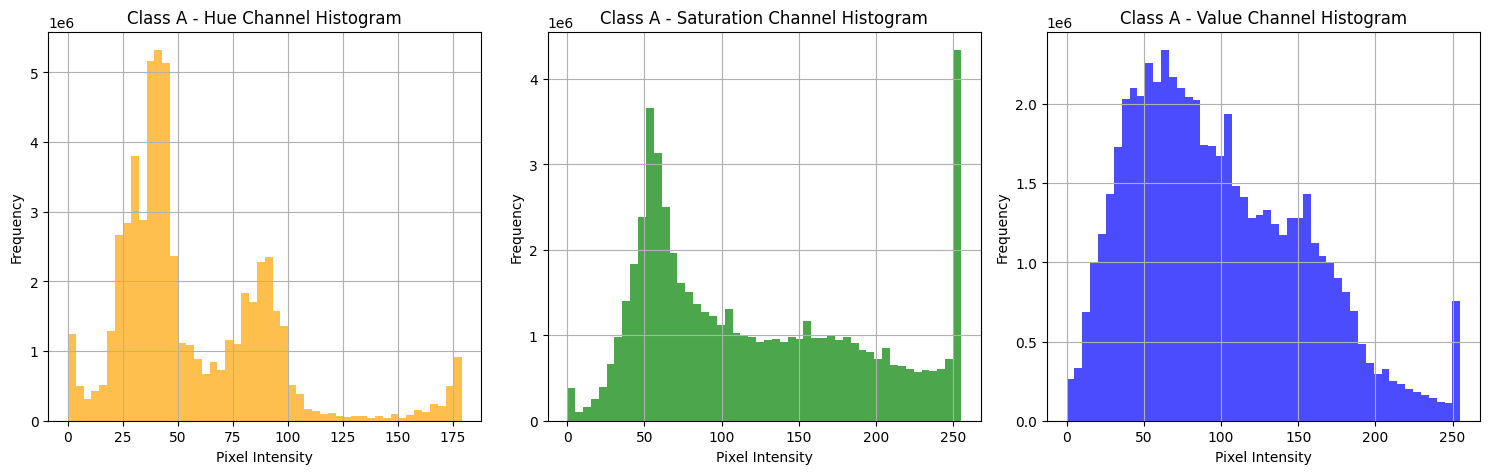

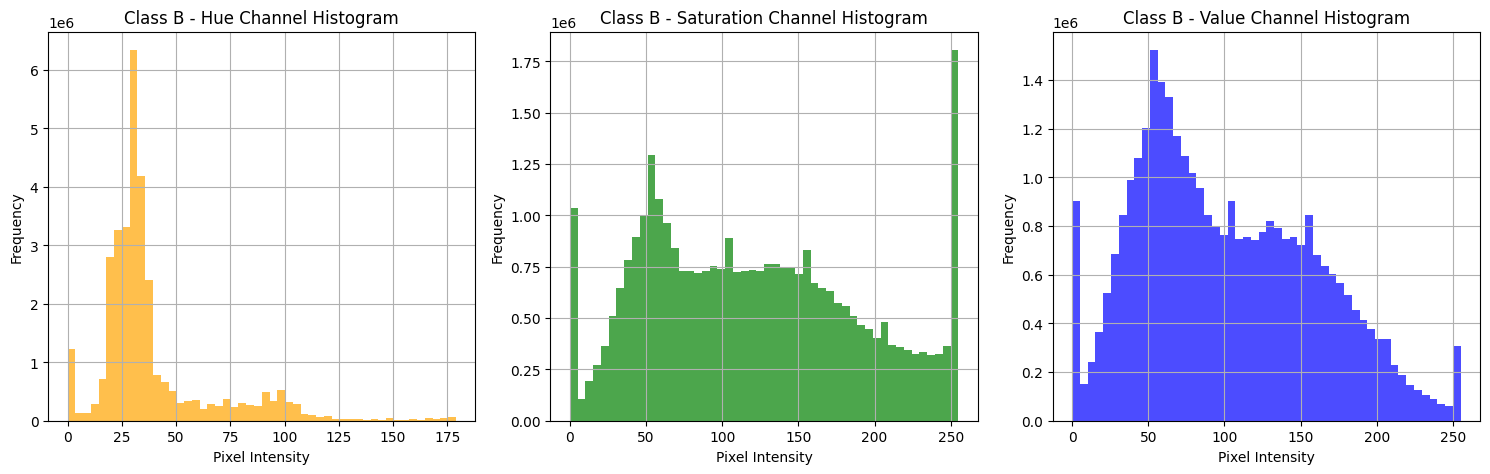

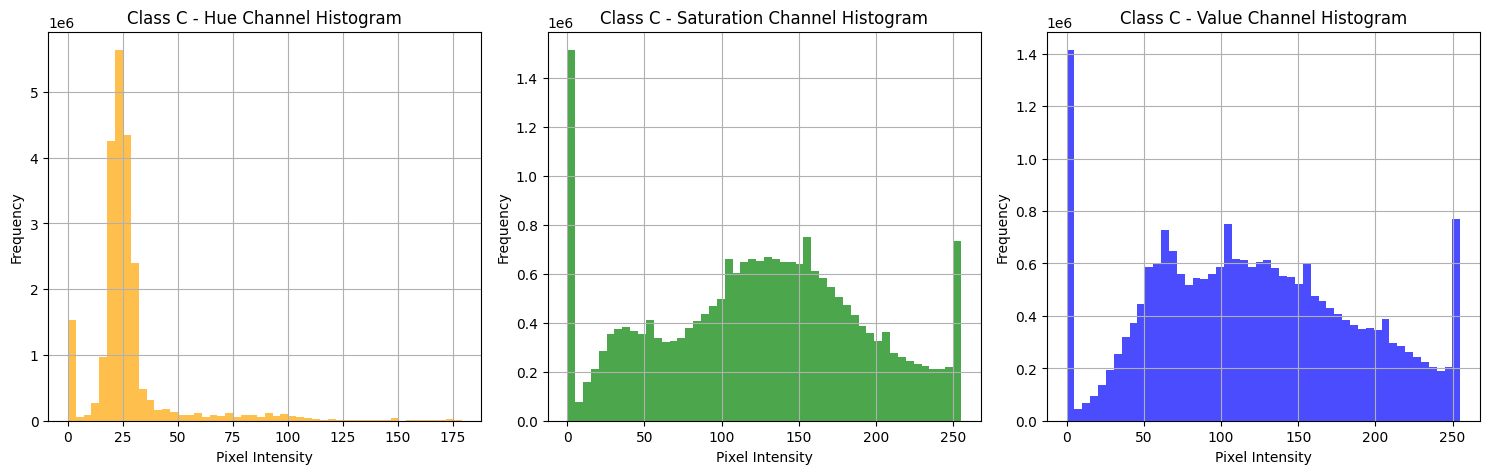

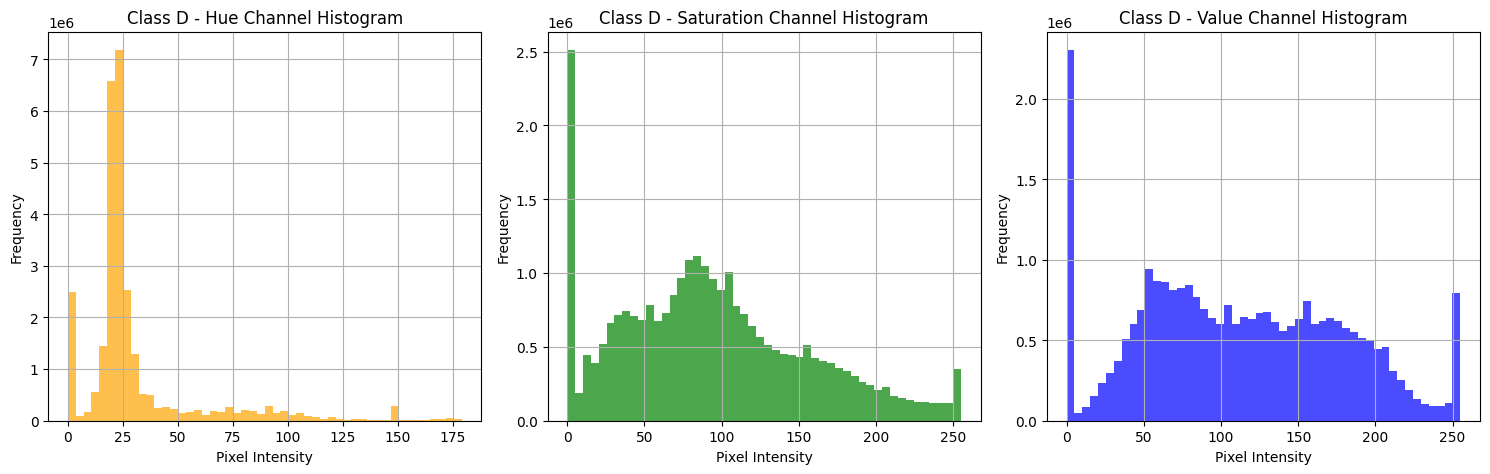

In [14]:
for class_name in CLASSES:
    hsv_stats = compute_hsv_channel_stats(TRAIN_DIR, class_name)
    plot_hsv_histograms(hsv_stats)

The pattern according to the above distribution looks as follows:
* Hue:
    * Class B, C, and D look similar.
    * Class A has a hue distribution of its own.
* Saturation:
    * Class A and B share a similar distribution here.
    * Class C and D share different distributions from A and B and among each other.
* Value:
    * We see a similar pattern here compared to saturation.
    * Class A and B are similar, whereas C and D seem different.

In [15]:
all_stats = []
for class_name in CLASSES:
    hsv_stats = compute_hsv_channel_stats("../data/train", class_name)

    for channel, stats in hsv_stats.items():
        stats_to_store = {
            "Class": class_name,
            "Channel": channel,
            "Mean": stats["mean"],
            "Std Dev": stats["std_dev"],
            "Median": stats["median"],
            "Min": stats["min"],
            "Max": stats["max"],
            "25th Percentile": stats["25th_percentile"],
            "75th Percentile": stats["75th_percentile"],
        }
        all_stats.append(stats_to_store)
hsv_stats_df = pd.DataFrame(all_stats)

In [16]:
hsv_stats_df[hsv_stats_df["Channel"] == "Hue"]

Class Channel       Mean    Std Dev  Median  Min  Max  25th Percentile  \
0  Class A     Hue  56.491261  35.641101    44.0    0  179             33.0   
3  Class B     Hue  38.982087  27.269231    31.0    0  179             25.0   
6  Class C     Hue  27.803849  21.119494    25.0    0  179             20.0   
9  Class D     Hue  30.548127  28.209461    23.0    0  179             19.0   

   75th Percentile  
0             81.0  
3             39.0  
6             28.0  
9             28.0

In [17]:
hsv_stats_df[hsv_stats_df["Channel"] == "Saturation"]

Class     Channel        Mean    Std Dev  Median  Min  Max  \
1   Class A  Saturation  122.234237  71.261315   105.0    0  255   
4   Class B  Saturation  120.935900  69.944737   115.0    0  255   
7   Class C  Saturation  123.782710  68.495812   127.0    0  255   
10  Class D  Saturation   93.429079  62.172103    87.0    0  255   

    25th Percentile  75th Percentile  
1              60.0            179.0  
4              61.0            172.0  
7              74.0            172.0  
10             46.0            132.0

In [18]:
hsv_stats_df[hsv_stats_df["Channel"] == "Value"]

Class Channel        Mean    Std Dev  Median  Min  Max  25th Percentile  \
2   Class A   Value   98.376096  55.522475    89.0    0  255             55.0   
5   Class B   Value  101.378438  58.268909    92.0    0  255             55.0   
8   Class C   Value  120.983205  67.263543   118.0    0  255             69.0   
11  Class D   Value  111.788873  66.682111   108.0    0  255             61.0   

    75th Percentile  
2             138.0  
5             145.0  
8             170.0  
11            164.0

Looking at the statistics or 'color moments', we see a similar pattern:
* Hue:
    * Class C and D look similar.
    * Class A has a hue distribution of its own and B is also slightly discernable.
* Saturation:
    * Class A and B share a similar distribution here.
    * Class C and D share different distributions from A and B and among each other.
* Value:
    * We see a similar pattern here compared to saturation.
    * Class A and B are similar, whereas C and D seem different.
    * However, class C and D are close but not as closs as A and B.

## LAB Statistics

* L describes the lightness of the color, A color component ranges from Green to Magenta, while B ranges from Blue to Yellow.
* This may be more useful for bananas, as we suspect the main focus colors would be shades of Green, Yellow, Brown, and Gray. Focus on color-specific features while ignoring variations in brightness.

In [19]:
def compute_lab_channel_stats(directory, class_name):
    channel_stats = {
        "L": {"pixel_values": [], "mean": 0, "std_dev": 0, "median": 0},
        "A": {"pixel_values": [], "mean": 0, "std_dev": 0, "median": 0},
        "B": {"pixel_values": [], "mean": 0, "std_dev": 0, "median": 0},
    }

    class_path = os.path.join(directory, class_name)
    image_files = os.listdir(class_path)

    for img_file in image_files:
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path)

        # Convert RGB image to LAB
        img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

        # Split channels (L, A, B)
        l, a, b = cv2.split(img_lab)

        # Compute statistics for each channel
        for channel, values in zip(["L", "A", "B"], [l, a, b]):
            channel_stats[channel]["pixel_values"].extend(values.flatten())

    for channel in channel_stats:
        pixel_values = np.array(channel_stats[channel]["pixel_values"])
        channel_stats[channel]["mean"] = np.mean(pixel_values)
        channel_stats[channel]["std_dev"] = np.std(pixel_values)
        channel_stats[channel]["median"] = np.median(pixel_values)
        channel_stats[channel]["min"] = np.min(pixel_values)
        channel_stats[channel]["max"] = np.max(pixel_values)
        channel_stats[channel]["25th_percentile"] = np.percentile(pixel_values, 25)
        channel_stats[channel]["75th_percentile"] = np.percentile(pixel_values, 75)

    return channel_stats

In [20]:
def plot_lab_histograms(channel_stats, class_name):
    channel_colors = {"L": "lightgray", "A": "green", "B": "blue"}

    plt.figure(figsize=(15, 5))
    for i, channel in enumerate(channel_stats):
        plt.subplot(1, len(channel_stats), i + 1)
        plt.hist(
            channel_stats[channel]["pixel_values"],
            bins=50,
            color=channel_colors[channel],
            alpha=0.7,
        )
        plt.title(f"{class_name} - {channel} Channel Histogram")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

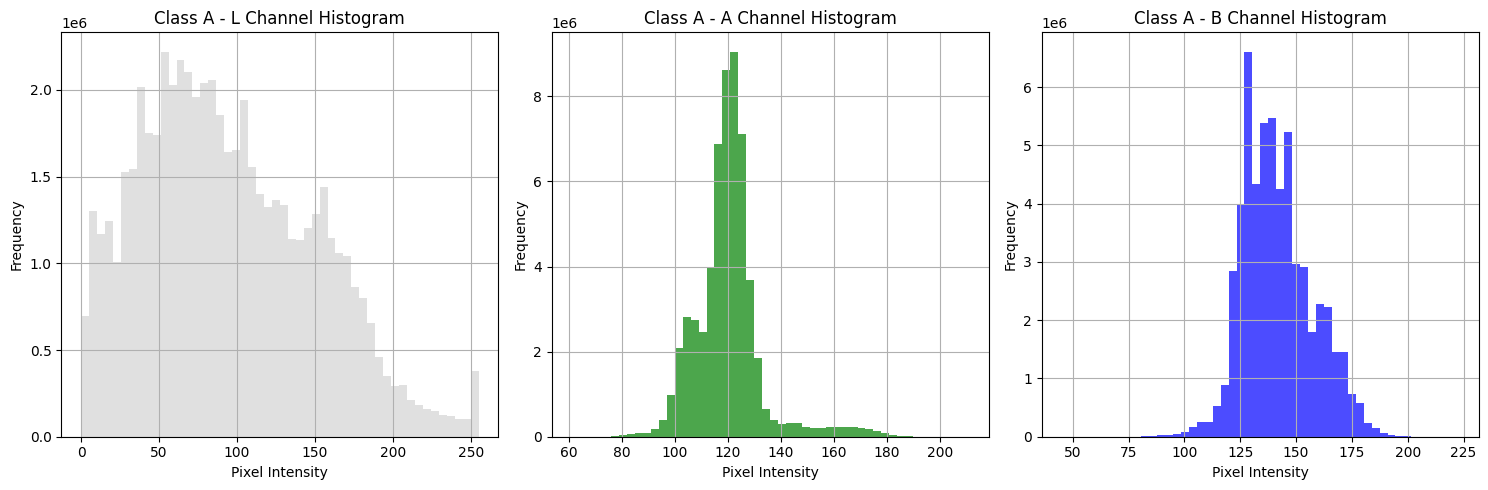

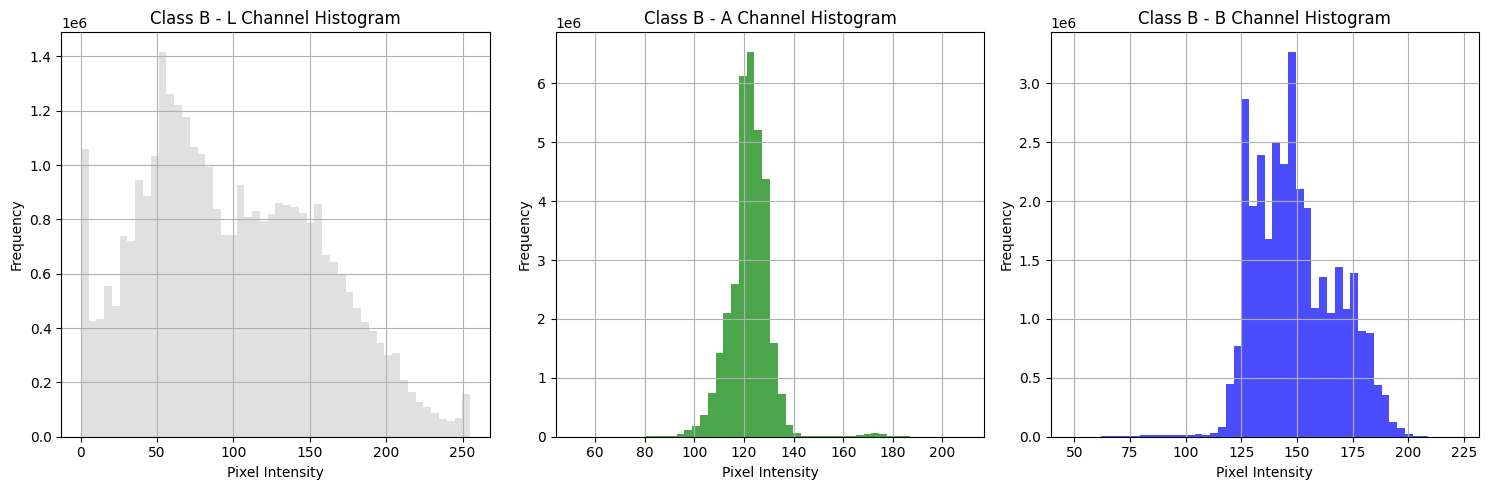

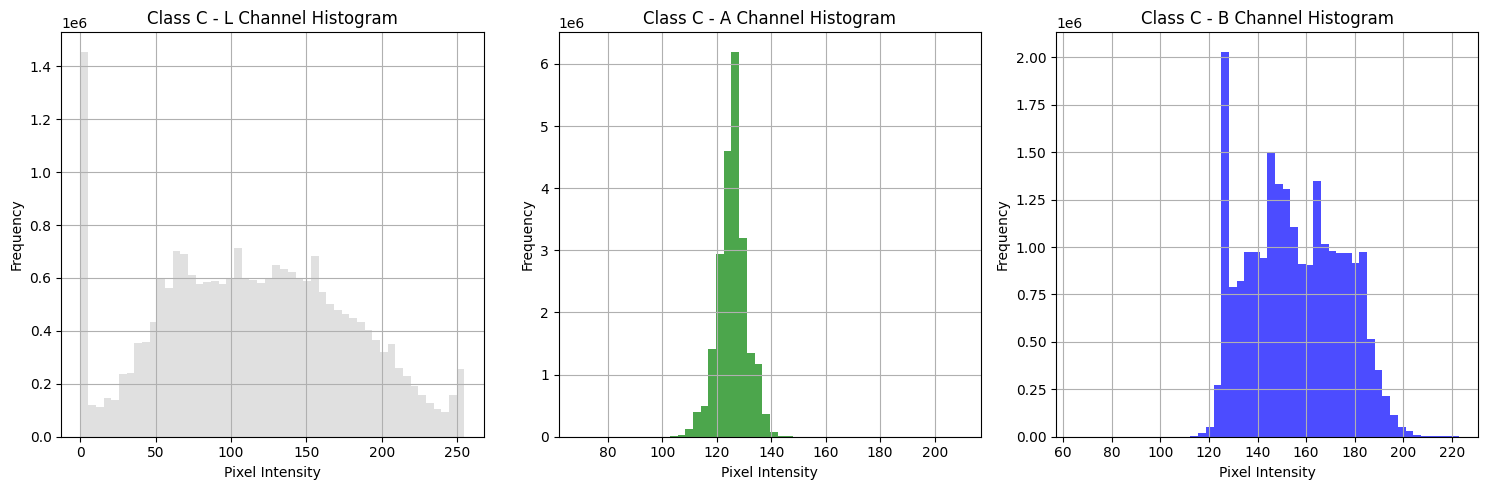

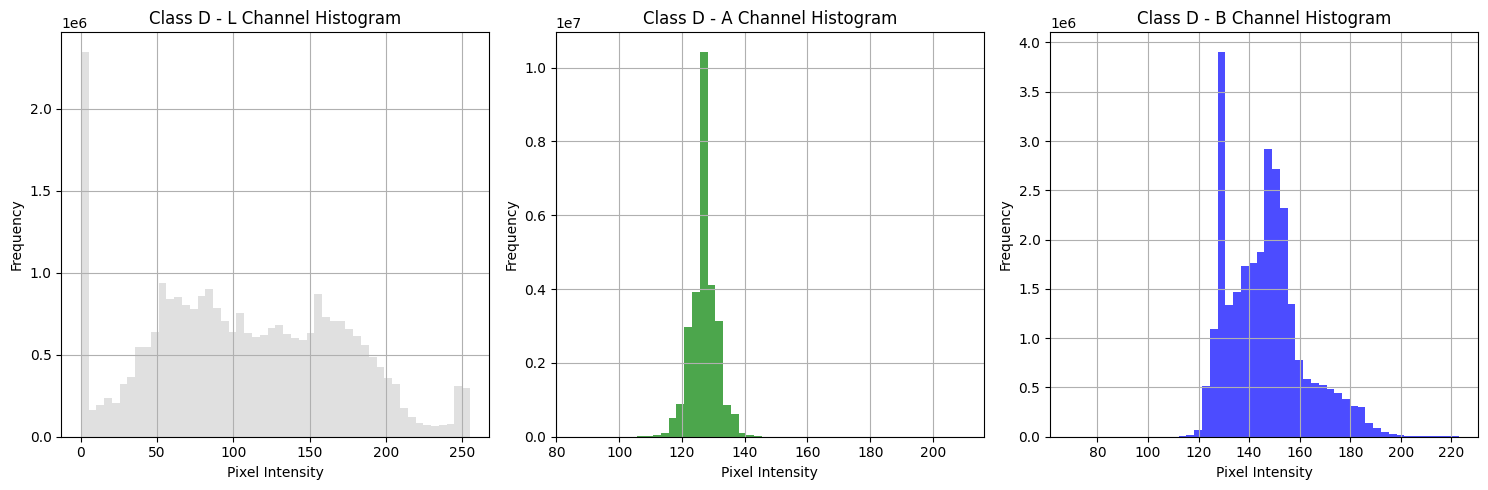

In [21]:
for class_name in CLASSES:
    lab_stats = compute_lab_channel_stats(TRAIN_DIR, class_name)
    plot_lab_histograms(lab_stats, class_name)

In [22]:
all_stats = []
for class_name in CLASSES:
    lab_stats = compute_lab_channel_stats("../data/train", class_name)

    for channel, stats in lab_stats.items():
        stats_to_store = {
            "Class": class_name,
            "Channel": channel,
            "Mean": stats["mean"],
            "Std Dev": stats["std_dev"],
            "Median": stats["median"],
            "Min": stats["min"],
            "Max": stats["max"],
            "25th Percentile": stats["25th_percentile"],
            "75th Percentile": stats["75th_percentile"],
        }
        all_stats.append(stats_to_store)
lab_stats_df = pd.DataFrame(all_stats)

In [23]:
lab_stats_df[lab_stats_df["Channel"] == "L"]

Class Channel        Mean    Std Dev  Median  Min  Max  25th Percentile  \
0  Class A       L   94.483528  55.196848    87.0    0  255             51.0   
3  Class B       L   99.245127  57.596430    92.0    0  255             54.0   
6  Class C       L  114.671027  62.851037   114.0    0  255             68.0   
9  Class D       L  106.881677  63.584005   103.0    0  255             59.0   

   75th Percentile  
0            134.0  
3            143.0  
6            161.0  
9            158.0

In [24]:
lab_stats_df[lab_stats_df["Channel"] == "A"]

Class Channel        Mean    Std Dev  Median  Min  Max  25th Percentile  \
1   Class A       A  119.675297  12.896334   120.0   61  211            114.0   
4   Class B       A  122.172039   8.366303   123.0   52  209            118.0   
7   Class C       A  125.925840   5.620291   126.0   69  210            123.0   
10  Class D       A  127.221855   4.579730   128.0   86  210            125.0   

    75th Percentile  
1             124.0  
4             127.0  
7             129.0  
10            129.0

In [25]:
lab_stats_df[lab_stats_df["Channel"] == "B"]

Class Channel        Mean    Std Dev  Median  Min  Max  25th Percentile  \
2   Class A       B  141.601934  15.707632   140.0   45  223            130.0   
5   Class B       B  149.141747  18.282802   147.0   48  223            135.0   
8   Class C       B  155.417165  19.136425   154.0   65  223            139.0   
11  Class D       B  146.248618  15.346697   146.0   69  223            134.0   

    75th Percentile  
2             151.0  
5             162.0  
8             171.0  
11            154.0

## t-SNE

* t-distributed Stochastic Neighbor Embedding (t-SNE) is a dimensionality reduction technique primarily used for visualizing high-dimensional data in lower dimensions, typically 2D or 3D.
* We'll try and use t-SNE to break down our features into three dimenions and see what they look like.

In [5]:
def load_tsne_images(image_dir):
    images = []
    for class_name in CLASSES:
        class_path = os.path.join(image_dir, class_name)
        for img_file in os.listdir(class_path):
            if img_file.lower().endswith(".png"):
                img_path = os.path.join(class_path, img_file)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (224, 224))
                img = img.astype("float32") / 255.0  # Normalize pixel values
                images.append(img)
    return np.array(images)

In [6]:
images = load_tsne_images(TRAIN_DIR)

In [7]:
reshaped_images = images.reshape((images.shape[0], -1))

In [8]:
tsne_components = {}

for class_name in CLASSES:
    start_index = sum(
        len(os.listdir(os.path.join(TRAIN_DIR, c)))
        for c in CLASSES[: CLASSES.index(class_name)]
    )
    end_index = start_index + len(os.listdir(os.path.join(TRAIN_DIR, class_name)))
    class_images = reshaped_images[start_index:end_index]

    tsne = TSNE(n_components=3, random_state=42)
    tsne_features = tsne.fit_transform(class_images)
    tsne_components[class_name] = tsne_features

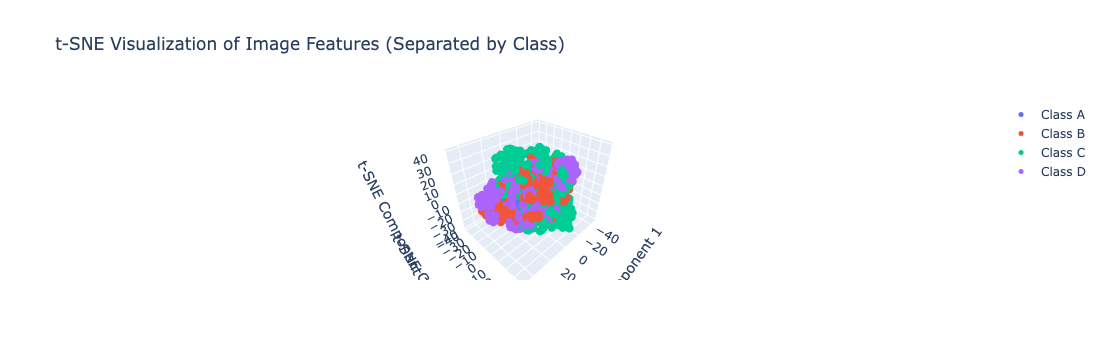

In [9]:
fig = go.Figure()

for class_name, tsne_features in tsne_components.items():
    fig.add_trace(
        go.Scatter3d(
            x=tsne_features[:, 0],
            y=tsne_features[:, 1],
            z=tsne_features[:, 2],
            mode="markers",
            marker=dict(size=5),
            name=class_name,
        )
    )

fig.update_layout(
    title="t-SNE Visualization of Image Features (Separated by Class)",
    scene=dict(
        xaxis_title="t-SNE Component 1",
        yaxis_title="t-SNE Component 2",
        zaxis_title="t-SNE Component 3",
    ),
)

fig.show()

* Looking at the graph alone it's hard to identify any separability among classes
* There doesn't seem to be a specific linear boundary when obersving it accross three dimensions.
* An SVM might work well here if we can reduce the dimensionality using PCA and map the values to a different feature space.